
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 最尤度

:label: `sec_maximum_likelihood`

機械学習で最も一般的に使用される考え方の 1 つは、最尤の観点です。これは、未知のパラメーターを含む確率モデルを扱う場合、データの確率を最も高くするパラメーターが最も可能性が高いという概念です。

## 最尤原理

これにはベイズ的な解釈があり、考えるのに役立ちます。パラメータ $\boldsymbol{\theta}$ とデータ例のコレクション $X$ を持つモデルがあると仮定します。具体的に言うと、$\boldsymbol{\theta}$ はコインを投げたときに表になる確率を表す単一の値であり、$X$ は一連の独立したコイン投げであると想像できます。この例については後で詳しく見ていきます。

モデルのパラメーターの最も可能性の高い値を見つけたい場合は、次の値を見つけたいことを意味します。

 $$\mathop{\mathrm{argmax}} P(\boldsymbol{\theta}\mid X).$$ :eqlabel: `eq_max_like`

ベイズの法則によれば、これは次と同じです。

 $$ \mathop{\mathrm{argmax}} \frac{P(X \mid \boldsymbol{\theta})P(\boldsymbol{\theta})}{P(X)}。 $$

データを生成するパラメータに依存しない確率である式 $P(X)$ は、$\boldsymbol{\theta}$ にまったく依存しないため、$\boldsymbol{\theta の最適な選択を変更せずに削除できます。 }$。同様に、どのパラメータ セットが他のパラメータ セットよりも優れているかについて事前の仮定がないと仮定することができるため、$P(\boldsymbol{\theta})$ も theta に依存しないと宣言できます。これは、たとえば、コイン投げの例で理にかなっています。この場合、表が出る確率は、事前にそれが公平であるかどうかを確信することなく $[0,1]$ の任意の値になる可能性があります (非*情報事前確率*と呼ばれることがよくあります)。したがって、ベイズ規則を適用すると、$\boldsymbol{\theta}$ の最良の選択が $\boldsymbol{\theta}$ の最尤推定値であることがわかります。

 $$ \hat{\boldsymbol{\theta}} = \mathop{\mathrm{argmax}} _ {\boldsymbol{\theta}} P(X \mid \boldsymbol{\theta})。 $$

一般的な用語として、パラメーター ($P(X \mid \boldsymbol{\theta})$) が与えられたデータの確率は、*尤度*と呼ばれます。

### 具体例

具体的な例でこれがどのように機能するかを見てみましょう。コイン投げが表である確率を表す単一のパラメーター $\theta$ があるとします。この場合、裏が得られる確率は $1-\theta$ なので、観測データ $X$ が $n_H$ の表と $n_T$ の裏をもつシーケンスである場合、独立した確率が乗算されるという事実を利用して、次のことがわかります。

 $$ P(X \mid \theta) = \theta^{n_H}(1-\theta)^{n_T}。 $$

 $13$ コインを投げて、$n_H = 9$ および $n_T = 4$ を持つシーケンス「HHHTHTTHHHHHT」を取得すると、これが次のとおりであることがわかります。

 $$ P(X \mid \theta) = \theta^9(1-\theta)^4。 $$

この例の 1 つの良い点は、答えがわかっていることです。実際、口頭で「コインを 13 枚投げたところ、9 枚が表になりました。コインが表になる確率についての最良の推測はどれくらいでしょうか?」と言うと、 、「誰もが$9/13$を正しく推測するでしょう。この最尤法によって得られるのは、非常に複雑な状況に一般化できる方法で、最初のプリンシパルからその数値を取得する方法です。

この例の場合、 $P(X \mid \theta)$ のプロットは次のようになります。


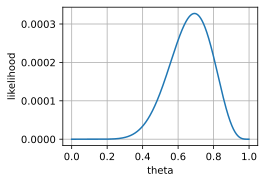

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

theta = torch.arange(0, 1, 0.001)
p = theta**9 * (1 - theta)**4.

d2l.plot(theta, p, 'theta', 'likelihood')


この最大値は、予想される $9/13 \約 0.7\ldots$ 付近にあります。それが正確に存在するかどうかを確認するには、微積分に目を向けることができます。最大値では、関数の勾配が平坦であることに注意してください。したがって、導関数がゼロである $\theta$ の値を見つけ、最も高い確率を与える値を見つけることによって、最尤推定値 :eqref: `eq_max_like`を見つけることができます。次のように計算します。

 $$ \begin{aligned} 0 &amp; = \frac{d}{d\theta} P(X \mid \theta) \ &amp; = \frac{d}{d\theta} \theta^9(1-\theta )^4 \ &amp; = 9\theta^8(1-\theta)^4 - 4\theta^9(1-\theta)^3 \ &amp; = \theta^8(1-\theta)^3(9 -13\θ)。 \end{整列} $$

これには、$0$、$1$、$9/13$ の 3 つの解決策があります。最初の 2 つは、確率 $0$ をシーケンスに割り当てているため、明らかに最大値ではなく最小値です。最終値はシーケンスにゼロ確率を割り当て*ない*ため、最尤推定値 $\hat \theta = 9/13$ でなければなりません。

## 数値最適化と負の対数尤度

前の例は素晴らしいですが、数十億のパラメーターとデータ例がある場合はどうなるでしょうか?

まず、すべてのデータ例が独立していると仮定すると、尤度自体は多くの確率の積であるため、実際には考慮できなくなることに注意してください。実際、各確率は $[0,1]$ にあり、通常約 $1/2$ の値であり、$(1/2)^{1000000000}$ の積は機械精度をはるかに下回ります。私たちはそれを直接扱うことはできません。

ただし、対数は積を和に変換することを思い出してください。

 $$ \log((1/2)^{1000000000}) = 1000000000\cdot\log(1/2) \およそ -301029995.6\ldots $$

この数値は、単精度 $32$ ビット浮動小数点数内にも完全に収まります。したがって、*対数尤度を*考慮する必要があります。

 $$ \log(P(X \mid \boldsymbol{\theta}))。 $$

関数 $x \mapsto \log(x)$ は増加しているため、尤度を最大化することは対数尤度を最大化することと同じです。実際、:numref: `sec_naive_bayes`では、単純ベイズ分類器の特定の例を操作するときにこの推論が適用されることがわかります。

私たちは損失を最小限に抑えたい損失関数を扱うことがよくあります。 $-\log(P(X \mid \boldsymbol{\theta}))$ を取得することで、最大尤度を損失の最小化に変えることができます。これは*負の対数尤度*です。

これを説明するために、以前のコイン投げ問題を考えて、閉じた形式の解法を知​​らないふりをします。それを計算してみよう

$$ -\log(P(X \mid \boldsymbol{\theta})) = -\log(\theta^{n_H}(1-\theta)^{n_T}) = -(n_H\log(\theta ) + n_T\log(1-\theta))。 $$

これはコードに書き込むことができ、数十億回のコイン投げでも自由に最適化できます。


In [2]:
# Set up our data
n_H = 8675309
n_T = 256245

# Initialize our paramteres
theta = torch.tensor(0.5, requires_grad=True)

# Perform gradient descent
lr = 1e-9
for iter in range(100):
    loss = -(n_H * torch.log(theta) + n_T * torch.log(1 - theta))
    loss.backward()
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.grad.zero_()

# Check output
theta, n_H / (n_H + n_T)

(tensor(0.9713, requires_grad=True), 0.9713101437890875)


人々が負の対数尤度を使用することを好む理由は、数値的な利便性だけではありません。それが好ましい理由は他にもいくつかあります。

対数尤度を考慮する 2 番目の理由は、微積分規則の適用を簡素化するためです。上で説明したように、独立性の仮定により、機械学習で遭遇する確率のほとんどは個別の確率の積です。

 $$ P(X\mid\boldsymbol{\theta}) = p(x_1\mid\boldsymbol{\theta})\cdot p(x_2\mid\boldsymbol{\theta})\cdots p(x_n\mid\boldsymbol {\シータ})。 $$

これは、積ルールを直接適用して導関数を計算すると、次の結果が得られることを意味します。

 $$ \begin{aligned} \frac{\partial}{\partial \boldsymbol{\theta}} P(X\mid\boldsymbol{\theta}) &amp; = \left(\frac{\partial}{\partial \ボールドシンボル{\theta}}P(x_1\mid\boldsymbol{\theta})\right)\cdot P(x_2\mid\boldsymbol{\theta})\cdots P(x_n\mid\boldsymbol{\theta}) \ &amp; \quad + P(x_1\mid\boldsymbol{\theta})\cdot \left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_2\mid\boldsymbol{\theta})\ right)\cdots P(x_n\mid\boldsymbol{\theta}) \ &amp; \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \vdots \ &amp; \quad + P(x_1\mid \boldsymbol{\theta})\cdot P(x_2\mid\boldsymbol{\theta}) \cdots \left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_n\mid\boldsymbol{ \シータ})\右)。 \end{整列} $$

これには $(n-1)$ の加算とともに $n(n-1)$ の乗算が必要なので、入力の二次時間に比例します。グループ化用語を十分に賢く使えば、これを線形時間に短縮できますが、それには少し考える必要があります。負の対数尤度については、代わりに次のようになります。

 $$ -\log\left(P(X\mid\boldsymbol{\theta})\right) = -\log(P(x_1\mid\boldsymbol{\theta})) - \log(P(x_2\mid \boldsymbol{\theta})) \cdots - \log(P(x_n\mid\boldsymbol{\theta})), $$

それは次に与えます

$$
-  \frac{\partial}{\partial \boldsymbol{\theta}} \log\left(P(X\mid\boldsymbol{\theta})\right) = \frac{1}{P(x_1\mid\boldsymbol {\theta})}\left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_1\mid\boldsymbol{\theta})\right) + \cdots + \frac{1}{ P(x_n\mid\boldsymbol{\theta})}\left(\frac{\partial}{\partial \boldsymbol{\theta}}P(x_n\mid\boldsymbol{\theta})\right)。 $$

これには $n$ の除算と $n-1$ の和だけが必要なので、入力では線形時間になります。

負の対数尤度を考慮する 3 番目および最後の理由は、情報理論との関係です。これについては、 :numref: `sec_information_theory`で詳しく説明します。これは、確率変数の情報またはランダム性の程度を測定する方法を提供する厳密な数学理論です。この分野の主要な研究対象はエントロピーです。

 $$ H(p) = -\sum_{i} p_i \log_2(p_i), $$

ソースのランダム性を測定します。これは平均 $-\log$ 確率にすぎないことに注意してください。したがって、負の対数尤度をとり、データ例の数で割ると、クロスエントロピーとして知られるエントロピーの相対値が得られます。この理論的解釈だけでも、モデルのパフォーマンスを測定する方法としてデータセット全体にわたる平均の負の対数尤度を報告する動機として十分に説得力があります。

## 連続変数の最尤度

これまで行ってきたことはすべて、離散確率変数を操作していることを前提としていますが、連続確率変数を操作したい場合はどうすればよいでしょうか?

簡単にまとめると、確率のすべてのインスタンスを確率密度に置き換える以外は何も変わりません。密度を小文字の $p$ で書くことを思い出してください。これは、たとえば次のように言うことを意味します。

 $$ -\log\left(p(X\mid\boldsymbol{\theta})\right) = -\log(p(x_1\mid\boldsymbol{\theta})) - \log(p(x_2\mid) \boldsymbol{\theta})) \cdots - \log(p(x_n\mid\boldsymbol{\theta})) = -\sum_i \log(p(x_i \mid \theta))。 $$

問題は「なぜこれがOKなのか？」ということです。結局のところ、密度を導入した理由は、特定の結果が得られる確率自体がゼロだったためであり、したがって、パラメータのセットに対してデータを生成する確率もゼロではないのでしょうか?

実際、これは事実であり、なぜ密度に移行できるのかを理解することは、イプシロンに何が起こるかを追跡する練習になります。

まずは目標を再定義しましょう。連続確率変数について、正確に正しい値が得られる確率を計算するのではなく、ある範囲 $\epsilon$ 内に一致するように計算したいとします。簡単にするために、データは同一に分布する確率変数 $X_1, \ldots, X_N$ の繰り返し観測値 $x_1, \ldots, x_N$ であると仮定します。前に見たように、これは次のように書くことができます。

 $$ \begin{aligned} &amp;P(X_1 \in [x_1, x_1+\epsilon], X_2 \in [x_2, x_2+\epsilon], \ldots, X_N \in [x_N, x_N+\epsilon]\mid\boldsymbol{\ theta}) \ \about &amp;\epsilon^Np(x_1\mid\boldsymbol{\theta})\cdot p(x_2\mid\boldsymbol{\theta}) \cdots p(x_n\mid\boldsymbol{\theta}) 。 \end{整列} $$

したがって、これの負の対数を取ると、次のようになります。

 $$ \begin{aligned} &amp;-\log(P(X_1 \in [x_1, x_1+\epsilon], X_2 \in [x_2, x_2+\epsilon], \ldots, X_N \in [x_N, x_N+\epsilon]\ Mid\boldsymbol{\theta})) \ \about &amp; -N\log(\epsilon) - \sum_{i} \log(p(x_i\mid\boldsymbol{\theta}))。 \end{整列} $$

この式を調べると、$\epsilon$ が出現する唯一の場所は加法定数 $-N\log(\epsilon)$ 内です。これはパラメータ $\boldsymbol{\theta}$ にはまったく依存しないため、$\boldsymbol{\theta}$ の最適な選択は $\epsilon$ の選択には依存しません。 4 桁または 400 を要求する場合、$\boldsymbol{\theta}$ の最適な選択は変わりません。したがって、最適化したいものを確認するためにイプシロンを自由に削除できます。

 $$
-  \sum_{i} \log(p(x_i\mid\boldsymbol{\theta}))。 $$

したがって、最尤法の観点は、確率を確率密度に置き換えることによって、離散確率変数と同じくらい簡単に連続確率変数を操作できることがわかります。

## まとめ
- 最尤原理により、特定のデータセットに最も適合するモデルは、最も高い確率でデータを生成するモデルであることがわかります。
- 多くの場合、人々はさまざまな理由から、代わりに負の対数尤度を使用します。数値の安定性、積の和への変換 (およびその結果として生じる勾配計算の簡略化)、情報理論との理論的結びつきです。
- 離散設定で動機付けするのが最も簡単ですが、データポイントに割り当てられた確率密度を最大化することで、連続設定にも自由に一般化できます。

## 演習
1. 非負の確率変数の密度 $\alpha e^{-\alpha x}$ が値 $\alpha&gt;0$ であることがわかっているとします。確率変数から数値 $3$ という 1 つの観測値を取得します。 $\alpha$ の最尤推定値はいくらですか?
1. 平均は不明だが分散が $1$ のガウス分布から抽出されたサンプル ${x_i}_{i=1}^N$ のデータセットがあるとします。平均値の最尤推定値はいくらですか?



[ディスカッション](https://discuss.d2l.ai/t/1096)
